# Machine Learning to Classify Images into 'Snow' or 'Clear'

By: Yesica Lopez, Asna Shafiq, Jonathan So, Vicram Uppal

Link to presentation: 

Link to our github repo with preprocessing code and image tars: https://github.com/yesicalopez/ca-image-classification

# Setup and Preprocessing

## Load github code containing scripts and image tars

The preprocessing of the images (resizing to 50x50 and optinal greyscale) has already been run with the methods in preprocessing.py and the resulting images were zipped up and stored in the github repo

The target labels (Y) were also generated with the code in preprocessing.py and stored in the labels folder as CSVs. 

The label was generated by matching the image with the weather observation from the same time and checking the measured snow depth.

*   If snow depth was > 1cm the target label was marked as 'snow',
*   If < 1cm marked as 'clear'
*   If no snow_depth value was available it got marked as 'msng'



In [ ]:
# delete the folder if need to reload the git code
! rm -rf /content/ca-image-classification

In [ ]:
!git clone https://github.com/yesicalopez/ca-image-classification

Cloning into 'ca-image-classification'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 187 (delta 23), reused 48 (delta 20), pack-reused 136
Receiving objects: 100% (187/187), 157.52 MiB | 34.75 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [ ]:
% cd /content/ca-image-classification/weather_classification

/content/ca-image-classification/weather_classification


In [ ]:
 
# so now we can just unzip them
label_dir = "/content/ca-image-classification/weather_classification/resources/images/labels/"
 
image_dir = "/content/ca-image-classification/weather_classification/resources/images/resized/"
#image_dir = "/content/ca-image-classification/weather_classification/resources/images/greyscale/"
 
#image_tar = "vkc_50.tar.gz"
#label_file = "vkc.csv"
 
# hourly february 2021 images for ~50 stations (sometimes with multiple camera angles)
# has been resized to 50x50
image_tar = "all_feb_50.tar.gz"
label_file = "all_feb.csv"
 
test_image_tar = "wjr_feb_50.tar.gz"
test_label_file = "all_feb.csv"
 
!tar -xvf  "$image_dir/$image_tar" -C "$image_dir"
!tar -xvf  "$image_dir/$test_image_tar" -C "$image_dir"

Streaming output truncated to the last 5000 lines.
all_feb_50/RVAS_WXP_S_20210210_1400Z.jpg
all_feb_50/RVAS_WXP_S_20210210_1500Z.jpg
all_feb_50/RVAS_WXP_S_20210210_1600Z.jpg
all_feb_50/RVAS_WXP_S_20210210_1700Z.jpg
all_feb_50/RVAS_WXP_S_20210210_1800Z.jpg
all_feb_50/RVAS_WXP_S_20210210_1900Z.jpg
all_feb_50/RVAS_WXP_S_20210210_2000Z.jpg
all_feb_50/RVAS_WXP_S_20210210_2100Z.jpg
all_feb_50/RVAS_WXP_S_20210210_2200Z.jpg
all_feb_50/RVAS_WXP_S_20210210_2300Z.jpg
all_feb_50/RVAS_WXP_S_20210211_0000Z.jpg
all_feb_50/RVAS_WXP_S_20210211_0100Z.jpg
all_feb_50/RVAS_WXP_S_20210211_0200Z.jpg
all_feb_50/RVAS_WXP_S_20210211_0300Z.jpg
all_feb_50/RVAS_WXP_S_20210211_0400Z.jpg
all_feb_50/RVAS_WXP_S_20210211_0500Z.jpg
all_feb_50/RVAS_WXP_S_20210211_0600Z.jpg
all_feb_50/RVAS_WXP_S_20210211_0700Z.jpg
all_feb_50/RVAS_WXP_S_20210211_0800Z.jpg
all_feb_50/RVAS_WXP_S_20210211_0900Z.jpg
all_feb_50/RVAS_WXP_S_20210211_1000Z.jpg
all_feb_50/RVAS_WXP_S_20210211_1100Z.jpg
all_feb_50/RVAS_WXP_S_20210211_1300Z.jpg
all_fe

One station (WJR) is removed from the dataset so none of its images are used for training. We then load thost station's images into a separate dataset for later testing

In [ ]:
# load the images as numpy arrays
import preprocessing
 
# ignore COQ because it has no observations so labels we know are msng
# ignore WJR so we can use it for validation testing and not have any images of it be part of the training
ignore_stations = ["COQ", "WJR"]
X, Y = preprocessing.load_training_images(image_dir+image_tar.replace(".tar.gz", ""), label_dir + label_file, ignore_stations)
 
# load wjr separately 
wjr_x, wjr_y =  preprocessing.load_training_images(image_dir+test_image_tar.replace(".tar.gz", ""), label_dir + test_label_file)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


In [ ]:
print("X: ", X.shape)
print("Y ", Y.shape)

X:  (38601, 7500)
Y  (38601,)


In [ ]:
print("X: ", wjr_x.shape)
print("Y ", wjr_y.shape)

X:  (652, 7500)
Y  (652,)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from joblib import dump, load
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

## Further preprocessing

* Dropping images with missing target label

* Dropping images that are mostly black (night time)

In [ ]:
# drop images that have a label (Y) of msng
def removeMSNG(X, Y):
  to_delete = Y == 'msng'
  print("Deleting msng rows", np.count_nonzero(to_delete))
  X = np.delete(X, to_delete, axis=0)
  Y = np.delete(Y, to_delete, axis=0)
  return X, Y
 
X,Y = removeMSNG(X, Y)
wjr_x, wjr_y = removeMSNG(wjr_x, wjr_y)
print("X: ", X.shape)
print("Y ", Y.shape)
print("WJR X: ", wjr_x.shape)
print("WJR Y: ", wjr_y.shape)

Deleting msng rows 2986
Deleting msng rows 0
X:  (35615, 7500)
Y  (35615,)
WJR X:  (652, 7500)
WJR Y:  (652,)


In [ ]:
# drop images that are mostly black
def removeNightImages(x, y):
  meanValues = x.mean(axis=1)
  to_delete = meanValues < 50
  print("Deleting rows with night images", np.count_nonzero(to_delete))
  x = np.delete(x, to_delete, axis=0)
  y = np.delete(y, to_delete, axis=0)
  return x, y
 
X, Y = removeNightImages(X, Y)
wjr_x, wjr_y = removeNightImages(wjr_x, wjr_y)
print("X: ", X.shape)
print("Y: ", Y.shape)
print("WJR X: ", wjr_x.shape)
print("WJR Y: ", wjr_y.shape)

Deleting rows with night images 9053
Deleting rows with night images 174
X:  (26562, 7500)
Y:  (26562,)
WJR X:  (478, 7500)
WJR Y:  (478,)


## Data Insights

In [ ]:
snow_count = np.count_nonzero(Y == 'snow')
clear_count = np.count_nonzero(Y == 'clear')
print("snow count:", snow_count, "clear count:", clear_count)
print("wjr snow count:", np.count_nonzero(wjr_y == 'snow'), "wjr clear count:", np.count_nonzero(wjr_y == 'clear'))

snow count: 17177 clear count: 9385
wjr snow count: 186 wjr clear count: 292


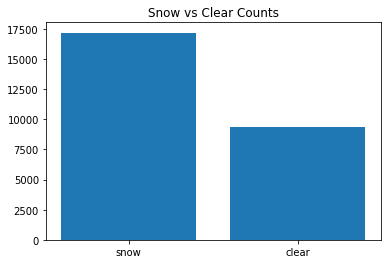

In [ ]:
# Spread of categories in X
plt.bar(["snow", "clear"], [snow_count, clear_count])
plt.title("Snow vs Clear Counts")
plt.show()

In [ ]:
# Define a function to plot image
def draw_image(data):
    image = data.reshape(50, 50, 3)
    plt.imshow(image, cmap = mpl.cm.binary, interpolation="nearest")
    plt.axis("off")
    plt.show()

### Sample Images in X

snow


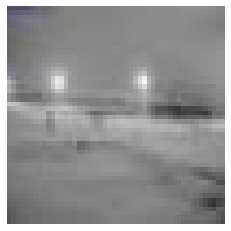

clear


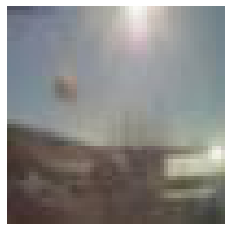

snow


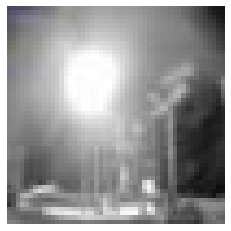

clear


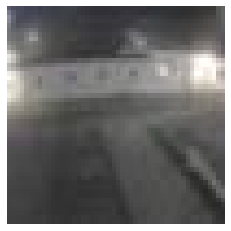

clear


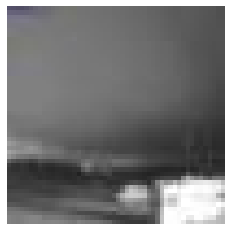

snow


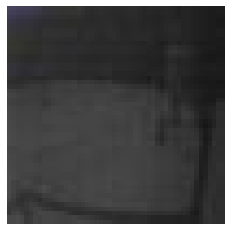

snow


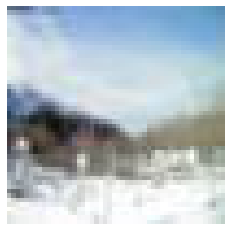

snow


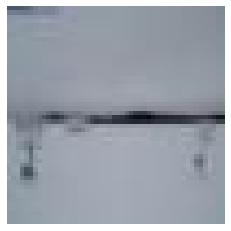

snow


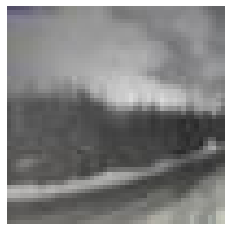

snow


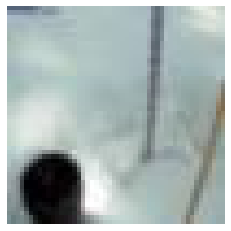

In [ ]:
for i in range(0,23000,2300):
  print(Y[i])
  draw_image(X[i])

### Sample Images in WJR

snow


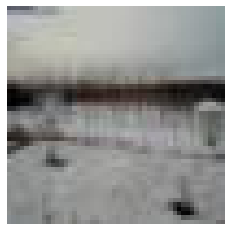

snow


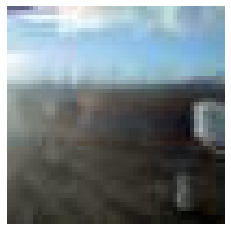

clear


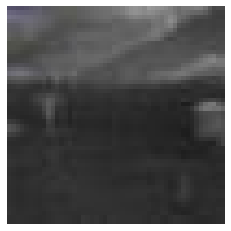

snow


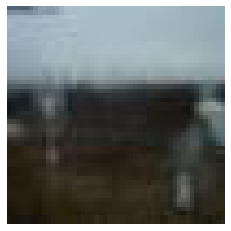

In [ ]:
for i in range(0,400,101):
  print(Y[i])
  draw_image(wjr_x[i])

### PCA 2 for visualization
Wanted to see what the data scatter plot looked like plotted by reducing down to 2 features

In [ ]:
# commented out the 2 lines below so we load the pretrained model instead

#pca2_knn3 = Pipeline([("pca", PCA(n_components=2))])
#pca2_knn3.fit(X_train, y_train)

In [ ]:
pca2_knn3 = load('trained_models/pca2_knn3.joblib') 

In [ ]:
pca2_knn3.named_steps["pca"].explained_variance_ratio_

array([0.43130333, 0.19772485])

visualize the data - though impotant to note only ~62% of the data variance is accounted for with 2 components PCA

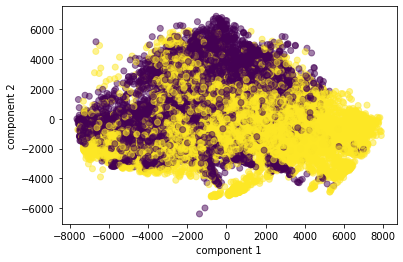

In [ ]:
# endcode Y label into number for the coloring
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
encoded_Y = labelencoder.fit_transform(Y)

# transform X
X_pca_2 = pca2_knn3.named_steps["pca"].transform(X)

plt.scatter(X_pca_2[:, 0], X_pca_2[:, 1], c=encoded_Y, alpha=0.5,cmap='viridis')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()

# Training 3 types of classification models

## Split train-test data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size= 0.2)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21249, 7500), (5313, 7500), (21249,), (5313,))

## K-Nearest Neighbours

In [ ]:
# reload the model if we previously trained it and want to skip the below cells
grid_search_knn = load('trained_models/knn_model.joblib') 

### GridSearch Training

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# gridsearch to find best n for knn
pipe_knn = Pipeline([
        ("pca", PCA(n_components=0.95)),
        ("knn", KNeighborsClassifier())
    ])

param_grid = [{
        "knn__n_neighbors": [3, 5, 10]
    }]

grid_search_knn = GridSearchCV(pipe_knn, param_grid, cv=3)

In [ ]:
grid_search_knn.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=0.95,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                  

### Picked Model Details

In [ ]:
print(grid_search_knn.best_score_)
print(grid_search_knn.best_params_)

0.973175208245094
{'knn__n_neighbors': 3}


In [ ]:
# PCA components shape
print(grid_search_knn.best_estimator_[0].components_.shape)
print(grid_search_knn.best_estimator_[0].explained_variance_ratio_)

(35, 7500)
[0.43130397 0.19888944 0.07839172 0.04609788 0.03171555 0.01943772
 0.01588498 0.01466385 0.01212954 0.00957758 0.00938025 0.00815976
 0.00677089 0.00567005 0.00554082 0.00537928 0.00471187 0.00413063
 0.00376309 0.00351847 0.00342092 0.00331347 0.00315264 0.0030173
 0.00270051 0.00256363 0.00234027 0.0022259  0.00217878 0.00208378
 0.00196754 0.00180513 0.00168997 0.00160834 0.00152218]


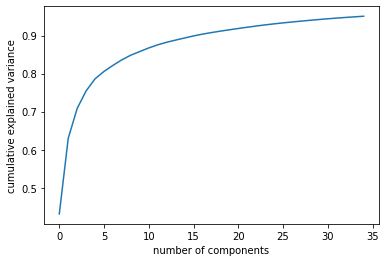

In [ ]:
# plot the variance ratio
plt.plot(np.cumsum(grid_search_knn.best_estimator_[0].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
knn_results = pd.DataFrame(grid_search_knn.cv_results_)
display(knn_results)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,500.526219,15.215632,1.326943,0.019308,3,{'knn__n_neighbors': 3},0.972610,0.972187,0.974728,0.973175,0.001112,1
1,505.309794,9.979348,1.664336,0.266130,5,{'knn__n_neighbors': 5},0.970210,0.970069,0.971199,0.970493,0.000502,2
2,494.674558,9.767291,1.785808,0.030371,10,{'knn__n_neighbors': 10},0.962445,0.964845,0.963151,0.963481,0.001007,3


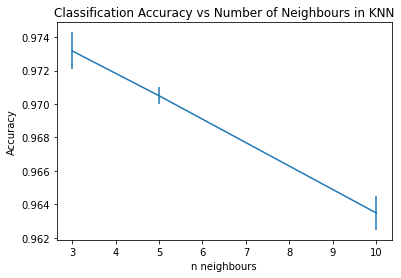

In [ ]:
# plot the scores
components_col = 'param_knn__n_neighbors'
best_clfs = knn_results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, title="Classification Accuracy vs Number of Neighbours in KNN", xlabel="n neighbours", ylabel="Accuracy")
plt.show()

In [ ]:
# we can save the trained model to reuse later
dump(grid_search_knn, 'knn_model.joblib')
files.download('knn_model.joblib')

['resources/trained_models/knn_model.joblib']

### Test Scores

In [ ]:
knn_train_score = grid_search_knn.score(X_train, y_train)
knn_test_score = grid_search_knn.score(X_test, y_test)
knn_wjr_score = grid_search_knn.score(wjr_x, wjr_y)

print("Train score", knn_train_score)
print("Test score", knn_test_score)
print("Test WJR score", knn_wjr_score)

Train score 0.9851757729775519
Test score 0.9856954639563336
Test WJR score 0.6401673640167364


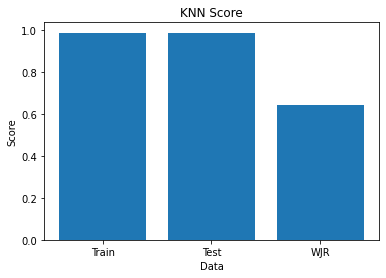

In [ ]:
plt.bar(["Train", "Test", "WJR"], [knn_train_score, knn_test_score, knn_wjr_score])
plt.title("KNN Score")
plt.ylabel("Score")
plt.xlabel("Data")
plt.show()

In [ ]:
knn_wjr_pred_y = grid_search_knn.predict(wjr_x)
knn_bad_predictions = knn_wjr_pred_y != wjr_y
print("Incorrect # of predictions for WJR using KNN", np.count_nonzero(knn_bad_predictions))

Incorrect # of predictions for WJR using KNN 172


Predicted snow but was clear


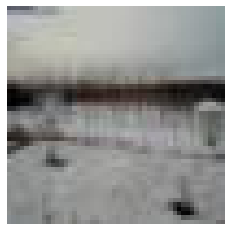

Predicted clear but was snow


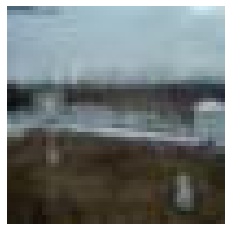

Predicted snow but was clear


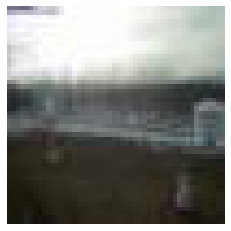

Predicted clear but was snow


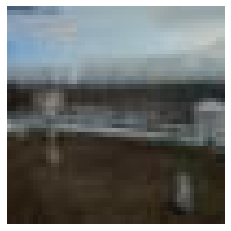

Predicted clear but was snow


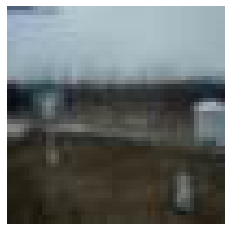

Predicted clear but was snow


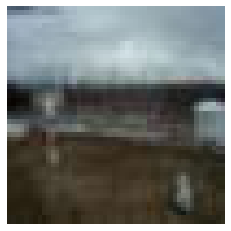

Predicted clear but was snow


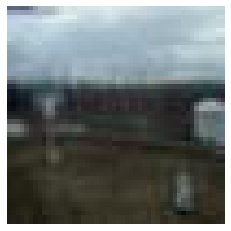

Predicted snow but was clear


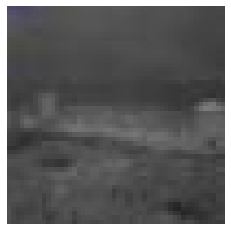

Predicted snow but was clear


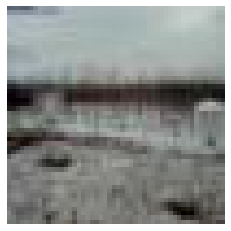

Predicted snow but was clear


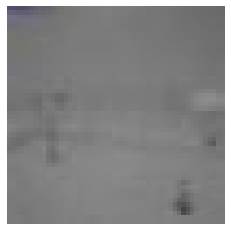

Predicted clear but was snow


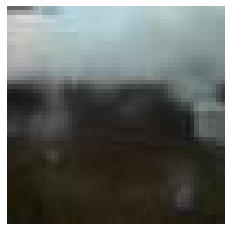

In [ ]:
# show some of the incorrect predictions
knn_bad_predictions_idx = np.where(knn_bad_predictions == True)[0]
for i in range(0,160,15):
  idx = knn_bad_predictions_idx[i]
  print("Predicted", knn_wjr_pred_y[idx], "but was", wjr_y[idx])
  draw_image(wjr_x[idx])

We can see above that for WJR, which the model had never seen made logical predictions based on the image. However, it is actually the Y label that is suspicious for some of them - due to the nature of how the label was generated (by using the measured snow_depth by a specific sensor that isn't always visible in the image)

The test dataset which had images for stations that were part of the training dateset performed much better, as the model was able to learn what those particular stations look like when it measures snow

## SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [ ]:
# reload the model if we previously trained it and want to skip the below cells
grid_search_svm = load('trained_models/svm_model.joblib') 

In [ ]:
# The RBF kernel of Support Vector Machines assume that all features are centered around 0 and have variance in the same order. 
SVM_pipeline = Pipeline([
    ('scalify', StandardScaler()),
    # 95% of variance
    ('pca', PCA(n_components=0.95)),
    ('svc', SVC(random_state=42))
])

In [ ]:
param_grid = {'svc__C': [0.1, 10], 'svc__gamma': [1, 0.1]}
grid_search_svm = GridSearchCV(SVM_pipeline, param_grid, cv=3, verbose = 3)
grid_search_svm.fit(X_train,y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] svc__C=0.1, svc__gamma=1 ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............ svc__C=0.1, svc__gamma=1, score=0.649, total= 7.7min
[CV] svc__C=0.1, svc__gamma=1 ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.7min remaining:    0.0s


[CV] ............ svc__C=0.1, svc__gamma=1, score=0.649, total= 7.7min
[CV] svc__C=0.1, svc__gamma=1 ........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 15.4min remaining:    0.0s


[CV] ............ svc__C=0.1, svc__gamma=1, score=0.649, total= 7.7min
[CV] svc__C=0.1, svc__gamma=0.1 ......................................
[CV] .......... svc__C=0.1, svc__gamma=0.1, score=0.654, total= 7.8min
[CV] svc__C=0.1, svc__gamma=0.1 ......................................
[CV] .......... svc__C=0.1, svc__gamma=0.1, score=0.653, total= 7.8min
[CV] svc__C=0.1, svc__gamma=0.1 ......................................
[CV] .......... svc__C=0.1, svc__gamma=0.1, score=0.653, total= 7.8min
[CV] svc__C=10, svc__gamma=1 .........................................
[CV] ............. svc__C=10, svc__gamma=1, score=0.656, total= 8.4min
[CV] svc__C=10, svc__gamma=1 .........................................
[CV] ............. svc__C=10, svc__gamma=1, score=0.655, total= 8.4min
[CV] svc__C=10, svc__gamma=1 .........................................
[CV] ............. svc__C=10, svc__gamma=1, score=0.656, total= 8.4min
[CV] svc__C=10, svc__gamma=0.1 .......................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 96.9min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scalify',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=0.95,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('svc',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                          

In [ ]:
print(grid_search_svm.best_estimator_)

Pipeline(memory=None,
         steps=[('scalify',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=0.95,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('svc',
                 SVC(C=10, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=0.1, kernel='rbf', max_iter=-1, probability=False,
                     random_state=42, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)
0.7074215257188573


Train score 0.9417384347498706
Test score 0.940523244871071
Test WJR score 0.3891213389121339


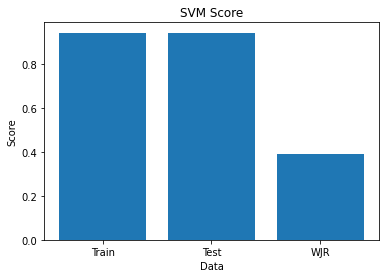

In [ ]:
# Train and test scores
svm_train_score = grid_search_svm.score(X_train, y_train)
svm_test_score = grid_search_svm.score(X_test, y_test)
svm_wjr_score = grid_search_svm.score(wjr_x, wjr_y)

print("Train score", svm_train_score)
print("Test score", svm_test_score)
print("Test WJR score", svm_wjr_score)

plt.bar(["Train", "Test", "WJR"], [svm_train_score, svm_test_score, svm_wjr_score])
plt.title("SVM Score")
plt.ylabel("Score")
plt.xlabel("Data")
plt.show()

In [ ]:
# we can save the trained model to reuse later
dump(grid_search_svm, 'svm_model.joblib')
files.download('svm_model.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Decision Trees - Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
 
def train_rfc_model(xTrain, yTrain):
  rfc_pipeline = Pipeline([
      ("pca", PCA(n_components=0.95,random_state=42)),
      ("rfc", RandomForestClassifier(random_state=42))
  ])  
  param_grid = { 
      'rfc__n_estimators': [50, 100, 250],
      'rfc__max_features': ['auto', 'log2'],
      'rfc__max_depth' : [5, 10, 25],
      'rfc__criterion' :['gini', 'entropy']
  }
  #use grid search to find better parameters
  rfc_cv = GridSearchCV(rfc_pipeline, param_grid, cv=3, verbose=3)
  rfc_cv.fit(xTrain, yTrain)
  return rfc_cv
 
def test_model(model, xTest, yTest):
  y_pred = model.predict(xTest)
  print(confusion_matrix(yTest,y_pred))
  print(classification_report(yTest,y_pred))
  print(accuracy_score(yTest, y_pred))

In [ ]:
from datetime import datetime
 
# reload the model if we previously trained it and want to skip the below cells
RELOAD_EXISTING_MODEL=False
 
if RELOAD_EXISTING_MODEL:
  rfc = load('trained_models/rfc_model.joblib')
else:
  rfc = train_rfc_model(X_train,y_train)
  out_file_name = 'rfc_model_' + datetime.today().strftime('%Y-%m-%dT%H:%M:%S') + '.joblib'

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] rfc__criterion=gini, rfc__max_depth=5, rfc__max_features=auto, rfc__n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  rfc__criterion=gini, rfc__max_depth=5, rfc__max_features=auto, rfc__n_estimators=50, score=0.893, total= 7.7min
[CV] rfc__criterion=gini, rfc__max_depth=5, rfc__max_features=auto, rfc__n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.7min remaining:    0.0s


[CV]  rfc__criterion=gini, rfc__max_depth=5, rfc__max_features=auto, rfc__n_estimators=50, score=0.883, total= 7.6min
[CV] rfc__criterion=gini, rfc__max_depth=5, rfc__max_features=auto, rfc__n_estimators=50 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 15.4min remaining:    0.0s


[CV]  rfc__criterion=gini, rfc__max_depth=5, rfc__max_features=auto, rfc__n_estimators=50, score=0.890, total= 7.8min
[CV] rfc__criterion=gini, rfc__max_depth=5, rfc__max_features=auto, rfc__n_estimators=100 
[CV]  rfc__criterion=gini, rfc__max_depth=5, rfc__max_features=auto, rfc__n_estimators=100, score=0.894, total= 7.8min
[CV] rfc__criterion=gini, rfc__max_depth=5, rfc__max_features=auto, rfc__n_estimators=100 
[CV]  rfc__criterion=gini, rfc__max_depth=5, rfc__max_features=auto, rfc__n_estimators=100, score=0.883, total= 7.9min
[CV] rfc__criterion=gini, rfc__max_depth=5, rfc__max_features=auto, rfc__n_estimators=100 
[CV]  rfc__criterion=gini, rfc__max_depth=5, rfc__max_features=auto, rfc__n_estimators=100, score=0.891, total= 7.9min
[CV] rfc__criterion=gini, rfc__max_depth=5, rfc__max_features=auto, rfc__n_estimators=250 
[CV]  rfc__criterion=gini, rfc__max_depth=5, rfc__max_features=auto, rfc__n_estimators=250, score=0.897, total= 8.1min
[CV] rfc__criterion=gini, rfc__max_depth=5

In [ ]:
#This is a duplicate of the last cell to run the GridSearch with additional parameters
from datetime import datetime
 
# reload the model if we previously trained it and want to skip the below cells
RELOAD_EXISTING_MODEL=False
 
if RELOAD_EXISTING_MODEL:
  rfc = load('trained_models/rfc_model.joblib')
else:
  rfc = train_rfc_model(X_train,y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] rfc__criterion=entropy, rfc__max_depth=5, rfc__max_features=auto, rfc__n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  rfc__criterion=entropy, rfc__max_depth=5, rfc__max_features=auto, rfc__n_estimators=50, score=0.886, total= 5.8min
[CV] rfc__criterion=entropy, rfc__max_depth=5, rfc__max_features=auto, rfc__n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.8min remaining:    0.0s


[CV]  rfc__criterion=entropy, rfc__max_depth=5, rfc__max_features=auto, rfc__n_estimators=50, score=0.891, total= 5.8min
[CV] rfc__criterion=entropy, rfc__max_depth=5, rfc__max_features=auto, rfc__n_estimators=50 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 11.7min remaining:    0.0s


[CV]  rfc__criterion=entropy, rfc__max_depth=5, rfc__max_features=auto, rfc__n_estimators=50, score=0.891, total= 6.0min
[CV] rfc__criterion=entropy, rfc__max_depth=5, rfc__max_features=auto, rfc__n_estimators=100 
[CV]  rfc__criterion=entropy, rfc__max_depth=5, rfc__max_features=auto, rfc__n_estimators=100, score=0.886, total= 6.3min
[CV] rfc__criterion=entropy, rfc__max_depth=5, rfc__max_features=auto, rfc__n_estimators=100 
[CV]  rfc__criterion=entropy, rfc__max_depth=5, rfc__max_features=auto, rfc__n_estimators=100, score=0.888, total= 6.1min
[CV] rfc__criterion=entropy, rfc__max_depth=5, rfc__max_features=auto, rfc__n_estimators=100 
[CV]  rfc__criterion=entropy, rfc__max_depth=5, rfc__max_features=auto, rfc__n_estimators=100, score=0.889, total= 6.1min
[CV] rfc__criterion=entropy, rfc__max_depth=5, rfc__max_features=auto, rfc__n_estimators=250 
[CV]  rfc__criterion=entropy, rfc__max_depth=5, rfc__max_features=auto, rfc__n_estimators=250, score=0.891, total= 6.5min
[CV] rfc__crite

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 343.1min finished


In [ ]:
#save the model if it was newly generated
if not RELOAD_EXISTING_MODEL:
  out_file_name = 'rfc_model_' + datetime.today().strftime('%Y-%m-%dT%H:%M:%S') + '.joblib'
  dump(rfc, out_file_name)
  files.download(out_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print(rfc.best_score_)
print(rfc.best_params_)

0.9749164666572545
{'rfc__criterion': 'entropy', 'rfc__max_depth': 25, 'rfc__max_features': 'auto', 'rfc__n_estimators': 250}


In [ ]:
rfc_results = pd.DataFrame(rfc.cv_results_)
display(rfc_results)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.916755,0.031271,0.063139,0.009344,gini,5,auto,10,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.905412,0.907529,0.906588,0.897882,0.899035,0.903289,0.004017,45
1,36.803130,0.416026,0.131773,0.002518,gini,5,auto,100,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.904941,0.913412,0.909882,0.904235,0.905390,0.907572,0.003529,37
2,91.704185,1.245174,0.252186,0.002686,gini,5,auto,250,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.900706,0.909882,0.911059,0.904000,0.902095,0.905548,0.004170,40
3,3.851433,0.028784,0.056739,0.001792,gini,5,sqrt,10,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.903059,0.904941,0.907294,0.898353,0.900683,0.902866,0.003133,46
4,36.558213,0.109386,0.131798,0.001848,gini,5,sqrt,100,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.902118,0.909882,0.910353,0.905647,0.905154,0.906631,0.003097,38
5,91.354891,0.832325,0.252935,0.001839,gini,5,sqrt,250,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.901412,0.910353,0.911294,0.902824,0.905154,0.906207,0.003965,39
6,0.782027,0.012250,0.055666,0.000274,gini,5,log2,10,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.883059,0.896000,0.883294,0.886118,0.888209,0.887336,0.004732,53
7,5.825602,0.013956,0.133062,0.005282,gini,5,log2,100,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.891294,0.898353,0.894824,0.889412,0.886797,0.892136,0.004062,49
8,14.165381,0.040888,0.250744,0.003323,gini,5,log2,250,"{'criterion': 'gini', 'max_depth': 5, 'max_fea...",0.890118,0.896706,0.896235,0.888235,0.887503,0.891759,0.003943,50
9,7.119419,0.012978,0.061812,0.001697,gini,10,auto,10,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.950588,0.953882,0.954824,0.950588,0.950341,0.952045,0.001910,30


In [ ]:
#test model with test split data
test_model(rfc, X_test, y_test)

[[1854   10]
 [  12 3437]]
              precision    recall  f1-score   support

       clear       0.99      0.99      0.99      1864
        snow       1.00      1.00      1.00      3449

    accuracy                           1.00      5313
   macro avg       1.00      1.00      1.00      5313
weighted avg       1.00      1.00      1.00      5313

0.9958592132505176


In [ ]:
#test model with test data from new station WJR 
test_model(rfc, wjr_x, wjr_y)

[[228  64]
 [125  61]]
              precision    recall  f1-score   support

       clear       0.65      0.78      0.71       292
        snow       0.49      0.33      0.39       186

    accuracy                           0.60       478
   macro avg       0.57      0.55      0.55       478
weighted avg       0.58      0.60      0.58       478

0.604602510460251


Train score 0.9961409948703468
Test score 0.9960474308300395
Test WJR score 0.604602510460251


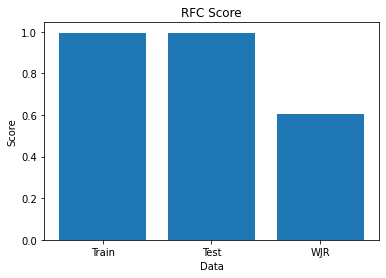

In [ ]:
# Train and test scores
rfc_train_score = rfc.score(X_train, y_train)
rfc_test_score = rfc.score(X_test, y_test)
rfc_wjr_score = rfc.score(wjr_x, wjr_y)

print("Train score", rfc_train_score)
print("Test score", rfc_test_score)
print("Test WJR score", rfc_wjr_score)

plt.bar(["Train", "Test", "WJR"], [rfc_train_score, rfc_test_score, rfc_wjr_score])
plt.title("RFC Score")
plt.ylabel("Score")
plt.xlabel("Data")
plt.show()

# Comparing Models Performance


### Accuracy Scores

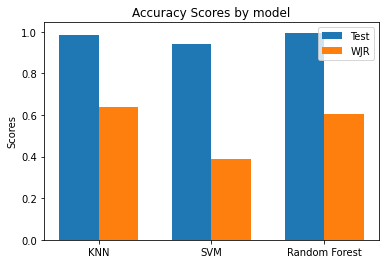

In [ ]:
scores_labels = ["KNN", "SVM", "Random Forest"]
scores_values_test = [knn_test_score, svm_test_score, rfc_test_score]
scores_values_wjr = [knn_wjr_score, svm_wjr_score, rfc_wjr_score]

x_bar = np.arange(len(scores_labels))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x_bar - width/2, scores_values_test, width, label='Test')
rects2 = ax.bar(x_bar + width/2, scores_values_wjr, width, label='WJR')

ax.set_ylabel('Scores')
ax.set_title('Accuracy Scores by model')
ax.set_xticks(x_bar)
ax.set_xticklabels(scores_labels)
ax.legend()

plt.show()

### Training Time

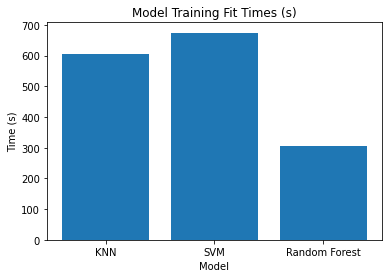

In [ ]:
plt.bar(scores_labels, [grid_search_knn.refit_time_, grid_search_svm.refit_time_, rfc.refit_time_])
plt.title("Model Training Fit Times (s)")
plt.ylabel("Time (s)")
plt.xlabel("Model")
plt.show()

### ROC Curves

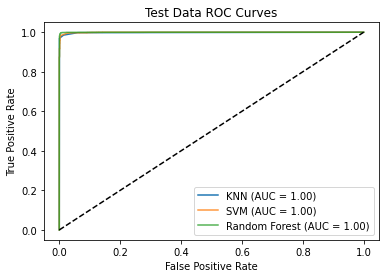

In [ ]:
# X_test

# knn
roc_curve_test_knn = metrics.plot_roc_curve(grid_search_knn, X_test, y_test, name="KNN")  

# svm
ax = plt.gca()
roc_curve_test_svm = metrics.plot_roc_curve(grid_search_svm, X_test, y_test, ax=ax, alpha=0.8, name="SVM")

# random forest
roc_curve_test_rf = metrics.plot_roc_curve(rfc, X_test, y_test, ax=ax, alpha=0.8, name="Random Forest")

plt.plot([0, 1], [0, 1], 'k--')
plt.title('Test Data ROC Curves')
plt.show()

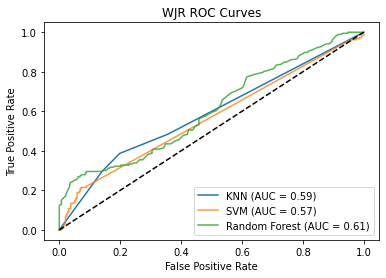

In [ ]:
# WJR

# knn
roc_curve_wjr_knn = metrics.plot_roc_curve(grid_search_knn, wjr_x, wjr_y, name="KNN")  

# svm
ax = plt.gca()
roc_curve_wjr_svm = metrics.plot_roc_curve(grid_search_svm, wjr_x, wjr_y, ax=ax, alpha=0.8, name="SVM")

# random forest
roc_curve_wjr_rf = metrics.plot_roc_curve(rfc, wjr_x, wjr_y, ax=ax, alpha=0.8, name="Random Forest")

plt.plot([0, 1], [0, 1], 'k--')
plt.title('WJR ROC Curves')
plt.show()